In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-05_10-18_20180401_20181231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2018-04-02 02:27:00,CL,BUY,1,65.30,1,ENTRY,2.37,0.00,"[CommissionReport(execId=1, commission=2.37, c...",100000.00
2018-04-02 13:34:00,GC,BUY,3,1337.20,3,ENTRY,7.26,0.00,"[CommissionReport(execId=2, commission=7.26, c...",100000.00
2018-04-02 13:48:00,GC,SELL,3,1336.90,4,STOP-LOSS,7.26,-104.52,"[CommissionReport(execId=3, commission=7.26, c...",99895.48
2018-04-02 14:05:00,GC,BUY,3,1338.10,5,ENTRY,7.26,0.00,"[CommissionReport(execId=4, commission=7.26, c...",99895.48
2018-04-02 14:33:00,CL,SELL,1,64.95,2,STOP-LOSS,2.37,-354.74,"[CommissionReport(execId=5, commission=2.37, c...",99540.74
...,...,...,...,...,...,...,...,...,...,...
2018-12-28 17:34:00,CL,BUY,1,45.16,2892,STOP-LOSS,2.37,-684.74,"[CommissionReport(execId=2888, commission=2.37...",173715.90
2018-12-28 20:38:00,NQ,BUY,3,6367.75,2893,ENTRY,6.30,0.00,"[CommissionReport(execId=2889, commission=6.30...",173715.90
2018-12-28 20:53:00,ES,BUY,3,2517.50,2895,ENTRY,6.30,0.00,"[CommissionReport(execId=2890, commission=6.30...",173715.90


In [4]:
df[df['contract']=='CL'].sort_values('realizedPNL').head(50)

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2018-12-07 19:35:00,CL,SELL,1,53.36,2626,STOP-LOSS,2.37,-814.74,"[CommissionReport(execId=2630, commission=2.37...",157321.24
2018-12-07 14:06:00,CL,SELL,1,51.78,2612,STOP-LOSS,2.37,-744.74,"[CommissionReport(execId=2608, commission=2.37...",159451.80
2018-11-23 17:20:00,CL,BUY,1,51.30,2468,STOP-LOSS,2.37,-724.74,"[CommissionReport(execId=2463, commission=2.37...",151084.68
2018-12-06 17:52:00,CL,BUY,1,50.93,2608,STOP-LOSS,2.37,-714.74,"[CommissionReport(execId=2603, commission=2.37...",158504.24
2018-12-28 17:34:00,CL,BUY,1,45.16,2892,STOP-LOSS,2.37,-684.74,"[CommissionReport(execId=2888, commission=2.37...",173715.90
2018-11-29 16:17:00,CL,SELL,1,50.85,2528,STOP-LOSS,2.37,-684.74,"[CommissionReport(execId=2523, commission=2.37...",142147.98
2018-11-27 11:03:00,CL,BUY,1,51.54,2486,STOP-LOSS,2.37,-674.74,"[CommissionReport(execId=2482, commission=2.37...",144721.62
2018-11-15 18:36:00,CL,SELL,1,56.77,2384,STOP-LOSS,2.37,-674.74,"[CommissionReport(execId=2380, commission=2.37...",144034.26
2018-11-28 11:05:00,CL,SELL,1,51.79,2502,STOP-LOSS,2.37,-644.74,"[CommissionReport(execId=2498, commission=2.37...",141695.88


In [5]:
df.groupby('contract').realizedPNL.sum()

contract
CL    -6750.38
ES    24814.20
GC   -28375.12
NQ    79787.00
Name: realizedPNL, dtype: float64

In [6]:
df.realizedPNL.sum()

69475.69999999998

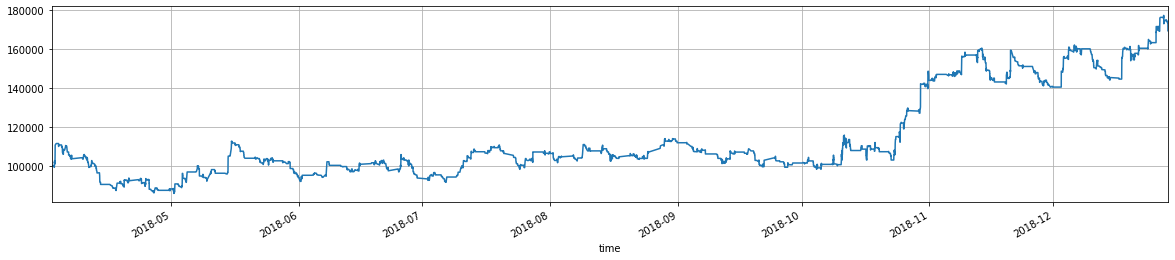

In [7]:
df.cash.plot(figsize=(20,4), grid=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL     574
ES     216
GC    1028
NQ    1074
Name: action, dtype: int64

In [10]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    1360.38
ES    1360.80
GC    9525.12
NQ    6573.00
Name: commission, dtype: float64

In [11]:
df.commission.sum()

18819.300000000003

In [12]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.37,-55.20,656.32,-472.46,1.39,-54.81,514.0
CL,0.34,-23.52,591.96,-337.74,1.75,-21.64,287.0
NQ,0.42,148.58,1356.63,-715.97,1.89,154.52,537.0
ES,0.43,229.76,3084.41,-1888.20,1.63,250.02,108.0
total,0.39,48.05,1127.27,-628.14,1.79,56.47,1446.0


In [13]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [14]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,1.000000,-0.128713,0.092928,-0.149254,-0.171995
ES,-0.128713,1.000000,0.005908,0.189557,0.727646
GC,0.092928,0.005908,1.000000,-0.062370,0.296547
NQ,-0.149254,0.189557,-0.062370,1.000000,0.651801
total,-0.171995,0.727646,0.296547,0.651801,1.000000


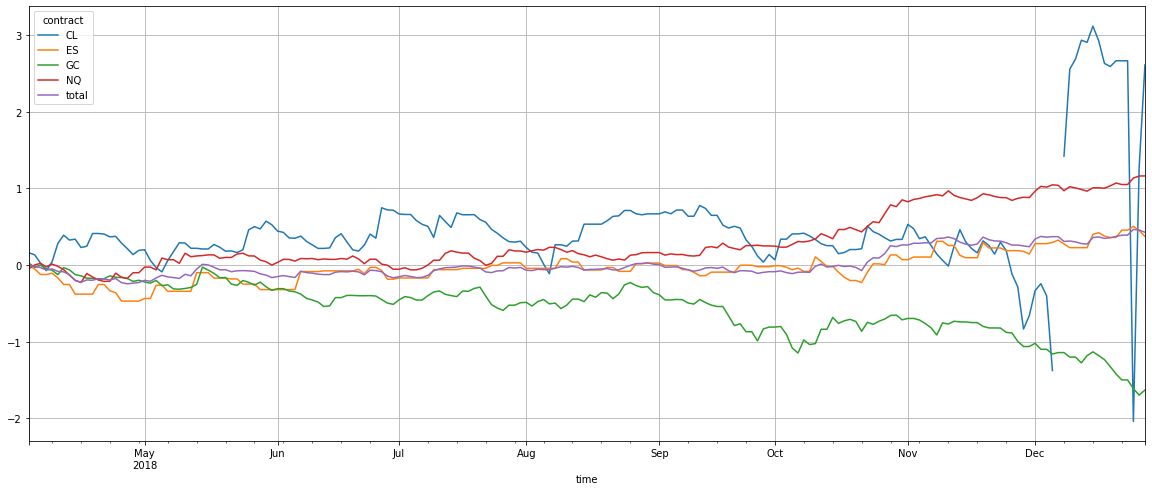

In [15]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

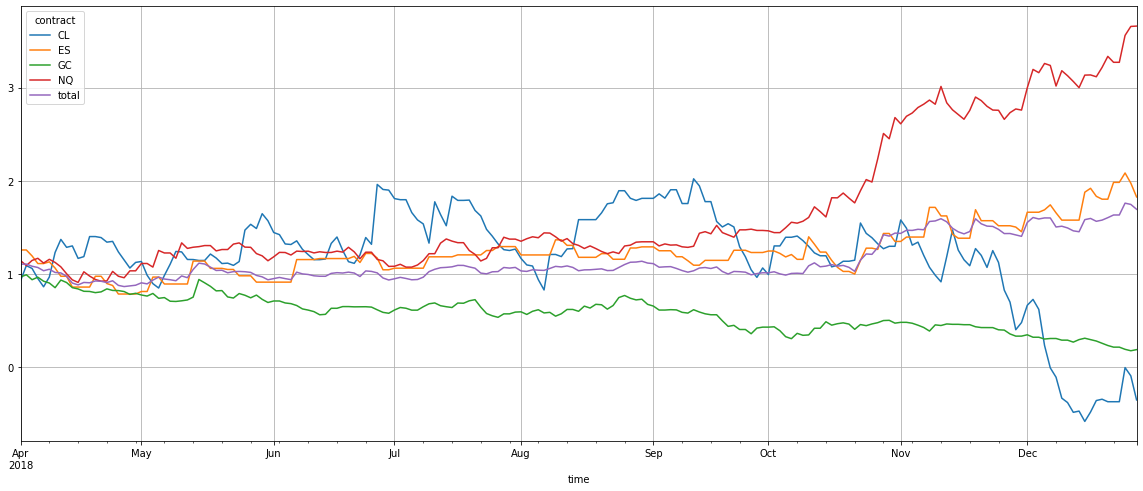

In [16]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [17]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,NaN,1.179163,-0.883640,4.347176,0.977322
Cumulative returns,-1.350076,0.827140,-0.810718,2.659567,0.694757
Annual volatility,35.200932,1.005011,0.962693,0.701188,0.502856
Sharpe ratio,1.661622,1.239235,-1.758472,2.735646,1.601226
Calmar ratio,NaN,3.140002,-1.074026,19.642945,4.488977
Stability,NaN,0.688316,0.799524,0.784974,0.666057
Max drawdown,-1.287317,-0.375529,-0.822736,-0.221310,-0.217716
Omega ratio,5.621944,1.363901,0.733838,1.629004,1.339485
Sortino ratio,28.387756,2.595653,-2.555833,5.642683,3.034126
Skew,10.387282,1.981002,1.008694,1.057492,1.194432


In [18]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,CL,ES,GC,NQ,total
time,,,,,
2018-04-30,21.06,-37.55,-18.01,-9.56,-20.42
2018-05-31,39.73,16.22,-12.43,10.43,6.64
2018-06-30,20.92,14.51,-16.63,-5.28,-0.25
2018-07-31,-33.29,23.79,2.15,27.03,14.43
2018-08-31,42.93,-0.23,14.02,-2.08,4.37
2018-09-30,-41.20,-4.68,-36.19,9.04,-9.34
2018-10-31,21.80,9.64,9.95,82.50,41.98
2018-11-30,-63.02,7.68,-29.41,2.99,-2.40
2018-12-31,2538.06,25.71,-43.36,32.66,20.66


In [19]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
CL       1263.0
ES         45.0
GC        -80.0
NQ        220.0
total      53.0
dtype: float64

In [20]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 20:42:00,ES,SELL,2795.75,9549.9
2018-11-20 16:38:00,ES,BUY,2657.00,9174.9
2018-12-17 16:56:00,ES,BUY,2594.25,8987.4
2018-10-31 15:48:00,NQ,SELL,6990.75,8927.4
2018-12-03 00:26:00,NQ,SELL,7085.25,8192.4
...,...,...,...,...
2018-12-27 21:11:00,ES,BUY,2430.75,-3275.1
2018-10-11 17:49:00,ES,BUY,2770.25,-3312.6
2018-11-21 08:31:00,ES,BUY,2656.00,-3537.6
